In [1]:
import pandas as pd
df = pd.read_csv("../Data/aggregated_spice_price_data_2019_2024.csv")
df

,Price Date,Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
0,2019-10-31,8476.100000,9156.250000,8854.900000
1,2019-11-01,8362.619048,10080.666667,9385.238095
2,2019-11-02,8228.023256,9744.162791,9147.720930
3,2019-11-03,8620.000000,8881.111111,8768.888889
4,2019-11-04,8185.625000,9976.950000,9199.375000
...,...,...,...,...
1822,2024-10-26,9873.513514,11910.000000,11096.297297
1823,2024-10-27,10366.666667,10916.666667,10635.166667
1824,2024-10-28,10333.593750,11987.500000,11361.281250
1825,2024-10-29,9893.684211,11420.263158,10820.263158


In [2]:
df = df[["Price Date", "Modal Price (Rs./Quintal)"]]
df.loc[:, 'Price Date'] = pd.to_datetime(df['Price Date'])
df.set_index('Price Date', inplace=True)
index_dtype = df.index.dtype
print(f"Datatype of the index: {index_dtype}")

Datatype of the index: datetime64[ns]


/Users/tejas/PycharmProjects/Spice_Price_Forecast/.venv/lib/python3.12/site-packages/pandas/core/indexes/base.py:7588: FutureWarning: Dtype inference on a pandas object (Series, Index, ExtensionArray) is deprecated. The Index constructor will keep the original dtype in the future. Call `infer_objects` on the result to get the old behavior.
  return Index(sequences[0], name=names)


In [3]:
import seaborn as sns
color_pal = sns.color_palette()

<Axes: title={'center': 'Modal Price'}, xlabel='Price Date'>

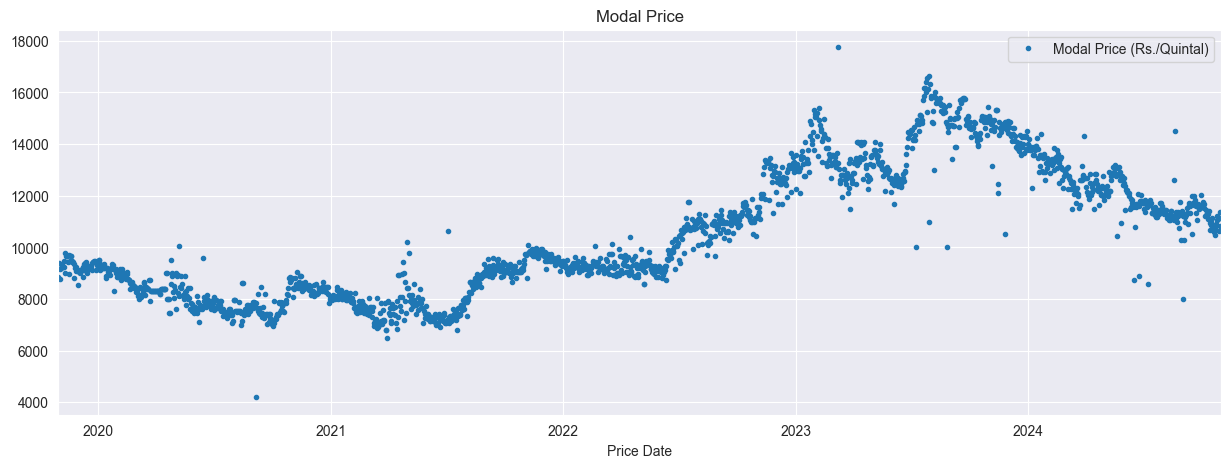

In [4]:
df.plot(style='.', figsize=(15, 5), color=color_pal[0], title="Modal Price", )

In [5]:
train_df = df.iloc[df.index<'01-01-2024']
test_df = df.iloc[df.index>='01-01-2024']

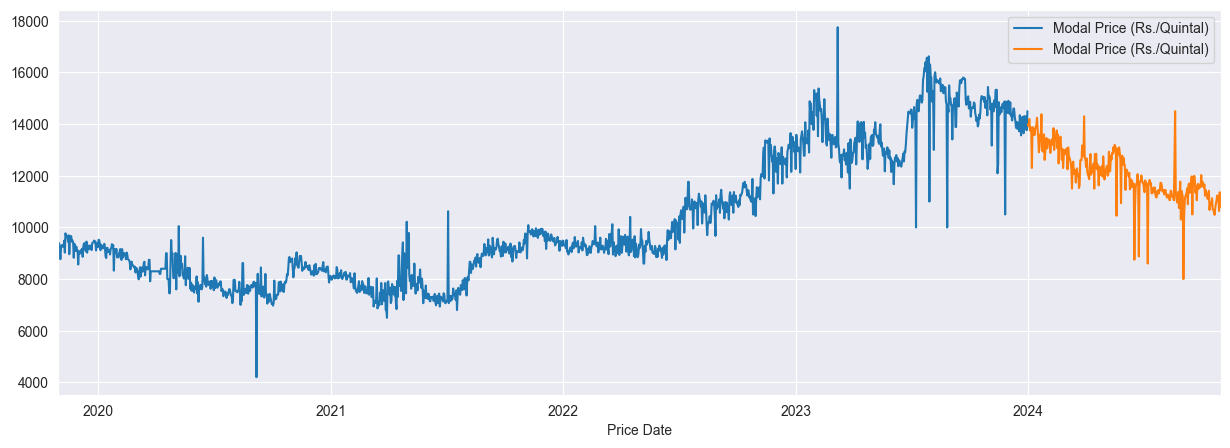

In [6]:
import matplotlib.pyplot as plt
fig, ax = plt.subplots(figsize=(15, 5))
train_df.plot(ax=ax, label='Training set')
test_df.plot(ax=ax, label='Test set')
plt.show()


<Axes: xlabel='Price Date'>

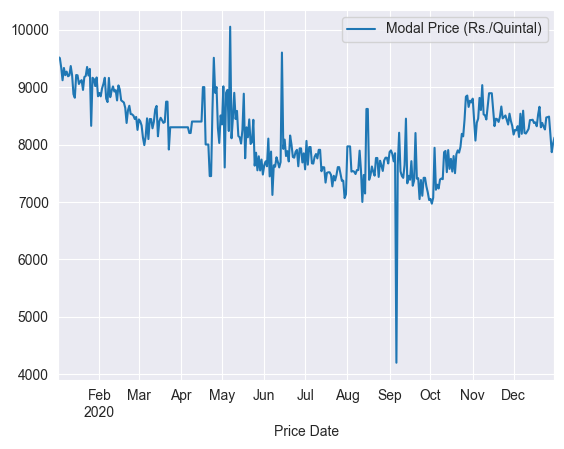

In [7]:
df.iloc[(df.index>'01-01-2020') & (df.index<'01-01-2021')].plot()

<Axes: xlabel='Price Date'>

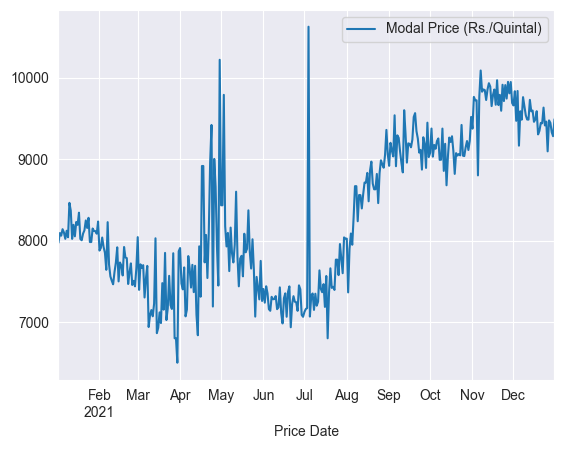

In [8]:
df.iloc[(df.index>'01-01-2021') & (df.index<'01-01-2022')].plot()

<Axes: xlabel='Price Date'>

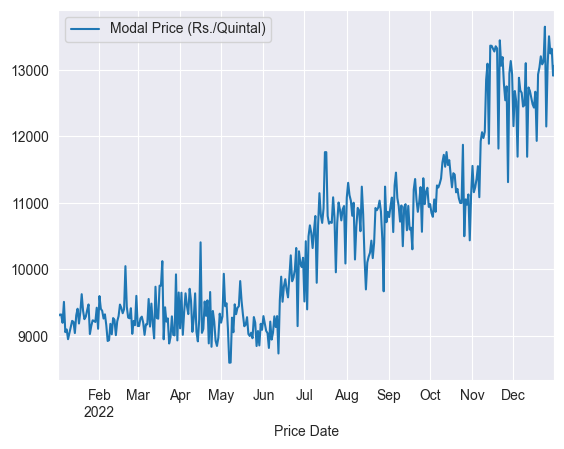

In [9]:
df.iloc[(df.index>'01-01-2022') & (df.index<'01-01-2023')].plot()

<Axes: xlabel='Price Date'>

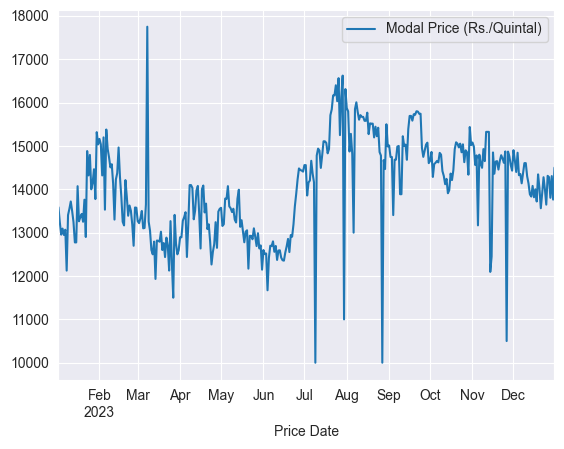

In [10]:
df.iloc[(df.index>'01-01-2023') & (df.index<'01-01-2024')].plot()

In [11]:
import pandas as pd

target_map = df['Modal Price (Rs./Quintal)'].to_dict()

def create_features(df):
    """
    Create time series features based on time series index for weekly forecasting.
    """
    df = df.copy()

    # Time-based features
    df['dayofweek'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['year'] = df.index.year
    df['dayofyear'] = df.index.dayofyear
    df['weekofyear'] = df.index.isocalendar().week

    # Lag features
    df['lag14'] = (df.index - pd.Timedelta('14 days')).map(target_map)
    df['lag28'] = (df.index - pd.Timedelta('28 days')).map(target_map)
    df['lag42'] = (df.index - pd.Timedelta('42 days')).map(target_map)
    df['lag56'] = (df.index - pd.Timedelta('56 days')).map(target_map)

    # Rolling window features
    for window in [14, 28, 42, 56]:
        df[f'rolling_mean_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).mean()
        df[f'rolling_median_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).median()
        df[f'rolling_std_{window}'] = df['Modal Price (Rs./Quintal)'].rolling(window=window, min_periods=1).std()

    # Exponential moving averages
    df['ema14'] = df['Modal Price (Rs./Quintal)'].ewm(span=14, adjust=False).mean()
    df['ema28'] = df['Modal Price (Rs./Quintal)'].ewm(span=28, adjust=False).mean()

    # Moving averages
    df['moving_avg_14'] = df['Modal Price (Rs./Quintal)'].rolling(window=14, min_periods=1).mean()
    df['moving_avg_28'] = df['Modal Price (Rs./Quintal)'].rolling(window=28, min_periods=1).mean()

    # Other statistical features
    df['max_56'] = df['Modal Price (Rs./Quintal)'].rolling(window=56, min_periods=1).max()
    df['min_56'] = df['Modal Price (Rs./Quintal)'].rolling(window=56, min_periods=1).min()
    df['range_56'] = df['max_56'] - df['min_56']

    return df


In [12]:
df = create_features(df)
df

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag14,lag28,lag42,...,rolling_mean_56,rolling_median_56,rolling_std_56,ema14,ema28,moving_avg_14,moving_avg_28,max_56,min_56,range_56
Price Date,,,,,,,,,,,,,,,,,,,,,
2019-10-31,8854.900000,3,4,10,2019,304,44,NaN,NaN,NaN,...,8854.900000,8854.900000,NaN,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,8854.900000,0.000000
2019-11-01,9385.238095,4,4,11,2019,305,44,NaN,NaN,NaN,...,9120.069048,9120.069048,375.005663,8925.611746,8891.475041,9120.069048,9120.069048,9385.238095,8854.900000,530.338095
2019-11-02,9147.720930,5,4,11,2019,306,44,NaN,NaN,NaN,...,9129.286342,9147.720930,265.649204,8955.226304,8909.147171,9129.286342,9129.286342,9385.238095,8854.900000,530.338095
2019-11-03,8768.888889,6,4,11,2019,307,44,NaN,NaN,NaN,...,9039.186979,9001.310465,281.989209,8930.381315,8899.474186,9039.186979,9039.186979,9385.238095,8768.888889,616.349206
2019-11-04,9199.375000,0,4,11,2019,308,45,NaN,NaN,NaN,...,9071.224583,9147.720930,254.500444,8966.247140,8920.157001,9071.224583,9071.224583,9385.238095,8768.888889,616.349206
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2024-10-26,11096.297297,5,4,10,2024,300,43,10675.000000,11568.166667,11972.347826,...,11235.943839,11321.725806,601.920489,11002.904952,11093.410950,10896.042643,11162.304372,12025.500000,8000.000000,4025.500000
2024-10-27,10635.166667,6,4,10,2024,301,43,10933.333333,12025.500000,10500.000000,...,11283.000386,11321.725806,419.795491,10953.873181,11061.807896,10874.745024,11112.649610,12025.500000,10299.166667,1726.333333
2024-10-28,11361.281250,0,4,10,2024,302,44,10973.571429,11597.147059,11728.529412,...,11301.966718,11341.906948,397.963193,11008.194257,11082.461231,10902.438583,11104.225831,12025.500000,10485.714286,1539.785714


In [13]:
# import pandas as pd
# import numpy as np
# from sklearn.metrics import mean_absolute_error
# from xgboost import XGBRegressor
# 
# # Custom metrics
# def smape(y_true, y_pred):
#     """Symmetric Mean Absolute Percentage Error"""
#     return 100 * np.mean(2 * np.abs(y_pred - y_true) / (np.abs(y_true) + np.abs(y_pred)))
# 
# def mdape(y_true, y_pred):
#     """Median Absolute Percentage Error"""
#     return 100 * np.median(np.abs((y_pred - y_true) / y_true))
# 
# def gmrae(y_true, y_pred):
#     """Geometric Mean Relative Absolute Error"""
#     numerator = np.abs(y_true - y_pred)
#     denominator = np.abs(y_true - np.mean(y_true))
#     ratio = numerator / denominator
#     return np.exp(np.mean(np.log(ratio + 1e-10)))
# 
# # Define target and features
# y = df['Modal Price (Rs./Quintal)']
# feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
# X = df[feature_columns]
# 
# # Define the base XGBoost model
# xgb_model = XGBRegressor(objective='reg:squarederror', random_state=42)
# 
# # Split into 5 sets, each of 30 days
# n_splits = 5
# 
# # Calculate total number of splits and test range
# total_days = len(y)
# split_size = total_days // n_splits
# 
# metrics_per_split = []
# 
# # Time-based split
# for i in range(n_splits):
#     # Define train and test indices
#     train_end = split_size * (i + 1) - test_days
#     test_start = train_end
#     test_end = split_size * (i + 1)
# 
#     X_train, X_test = X.iloc[:train_end], X.iloc[test_start:test_end]
#     y_train, y_test = y.iloc[:train_end], y.iloc[test_start:test_end]
# 
#     # Train the model
#     xgb_model.fit(X_train, y_train)
# 
#     # Predict
#     y_pred = xgb_model.predict(X_test)
# 
#     # Calculate metrics
#     rmse = np.sqrt(mean_absolute_error(y_test, y_pred))
#     mae = mean_absolute_error(y_test, y_pred)
#     smape_val = smape(y_test, y_pred)
#     mdape_val = mdape(y_test, y_pred)
#     gmrae_val = gmrae(y_test, y_pred)
# 
#     metrics_per_split.append({
#         'Split': i + 1,
#         'RMSE': rmse,
#         'MAE': mae,
#         'SMAPE': smape_val,
#         'MDAPE': mdape_val,
#         'GMRAE': gmrae_val
#     })
# 
# # Print metrics for each split
# for metrics in metrics_per_split:
#     print(f"Split {metrics['Split']}:")
#     for metric_name, metric_value in metrics.items():
#         if metric_name != 'Split':
#             print(f"  {metric_name}: {metric_value:.4f}")


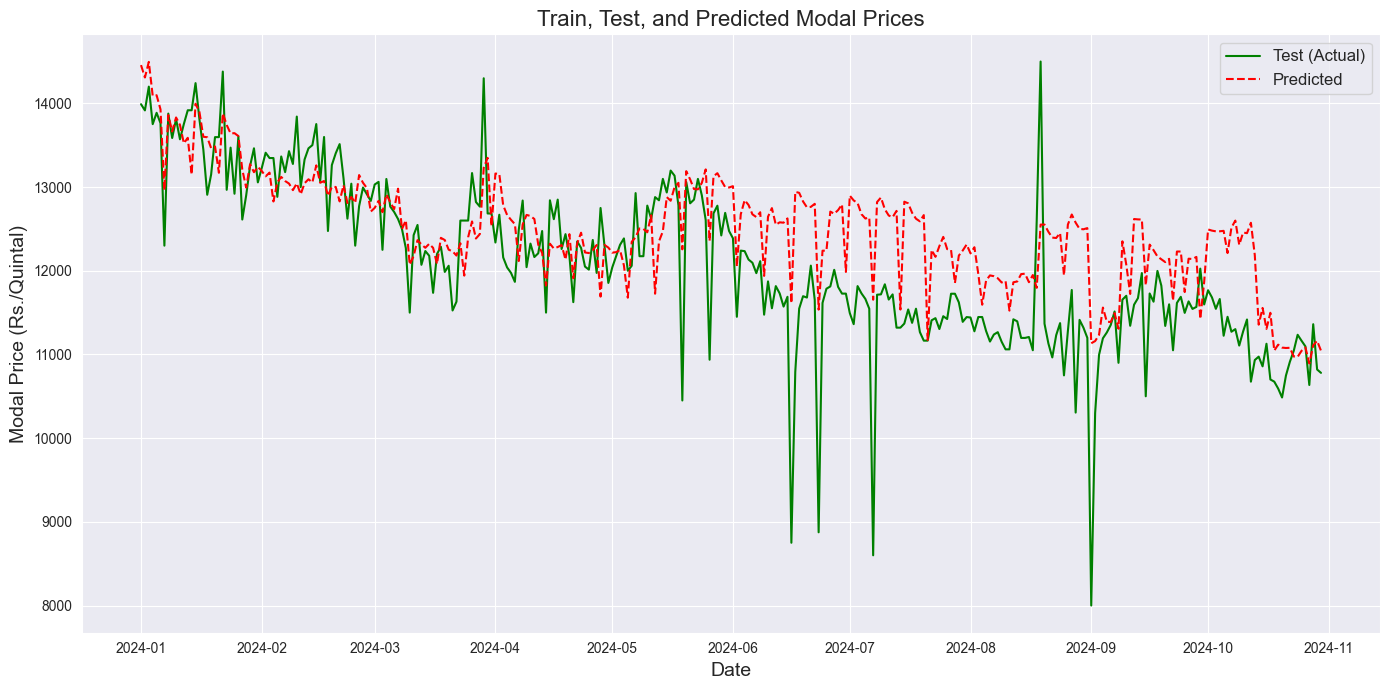

Metrics:
Mean Absolute Error (MAE): 594.5267
Symmetric Mean Absolute Percentage Error (SMAPE): 4.9679
Median Absolute Percentage Error (MDAPE): 4.0382
Geometric Mean Relative Absolute Error (GMRAE): 0.6987


In [14]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2023-12-31']
test_data = df.loc['2024-01-01':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']
model = XGBRegressor(objective='reg:squarederror', random_state=42)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))


# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red', linestyle='--')

# Add title and labels
plt.title("Train, Test, and Predicted Modal Prices", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


In [15]:
import pandas as pd
import numpy as np
from itertools import product
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming X_train, y_train, X_test, and y_test are defined
# Define the hyperparameter grid
param_grid = {
    'learning_rate': [0.01, 0.1, 0.2],
    'max_depth': [3, 5, 7],
    'n_estimators': [50, 100, 150],
    'booster': ['gbtree', 'dart']
}

# Generate all combinations of hyperparameters
param_combinations = list(product(
    param_grid['learning_rate'],
    param_grid['max_depth'],
    param_grid['n_estimators'],
    param_grid['booster']
))

# Store results for comparison
results = []

# Iterate through each parameter combination
for params in param_combinations:
    # Unpack parameters
    learning_rate, max_depth, n_estimators, booster = params

    # Define the model with the current parameters
    model = XGBRegressor(
        objective='reg:squarederror',
        learning_rate=learning_rate,
        max_depth=max_depth,
        n_estimators=n_estimators,
        booster=booster,
        random_state=42
    )

    # Train the model on the training data
    model.fit(X_train, y_train)

    # Predict on the test data
    y_pred = model.predict(X_test)

    # Evaluate performance using MAE
    mae = mean_absolute_error(y_test, y_pred)

    # Save the results
    results.append({
        'learning_rate': learning_rate,
        'max_depth': max_depth,
        'n_estimators': n_estimators,
        'booster': booster,
        'mae': mae
    })

    print(f"Evaluated params: {params} | MAE: {mae:.4f}")

# Convert results to a DataFrame for easy analysis
results_df = pd.DataFrame(results)

# Find the best parameters (lowest MAE)
best_params = results_df.loc[results_df['mae'].idxmin()]

# Print the best parameters and corresponding score
print("\nBest Parameters:")
print(best_params)

# Train the final model with the best parameters
final_model = XGBRegressor(
    objective='reg:squarederror',
    learning_rate=best_params['learning_rate'],
    max_depth=int(best_params['max_depth']),
    n_estimators=int(best_params['n_estimators']),
    booster=best_params['booster'],
    random_state=42
)

final_model.fit(X_train, y_train)
y_pred_final = final_model.predict(X_test)

# Calculate metrics for the final model
final_mae = mean_absolute_error(y_test, y_pred_final)
print(f"\nFinal Model MAE: {final_mae:.4f}")

# Output the final predictions for visualization or further analysis
print("\nFinal Predictions:")
print(pd.DataFrame({'Actual': y_test.values, 'Predicted': y_pred_final}, index=y_test.index).head())


Evaluated params: (0.01, 3, 50, 'gbtree') | MAE: 1020.3508
Evaluated params: (0.01, 3, 50, 'dart') | MAE: 1020.3508
Evaluated params: (0.01, 3, 100, 'gbtree') | MAE: 582.4465
Evaluated params: (0.01, 3, 100, 'dart') | MAE: 582.4465
Evaluated params: (0.01, 3, 150, 'gbtree') | MAE: 495.1475
Evaluated params: (0.01, 3, 150, 'dart') | MAE: 495.1475
Evaluated params: (0.01, 5, 50, 'gbtree') | MAE: 1194.6795
Evaluated params: (0.01, 5, 50, 'dart') | MAE: 1194.6795
Evaluated params: (0.01, 5, 100, 'gbtree') | MAE: 673.9442
Evaluated params: (0.01, 5, 100, 'dart') | MAE: 673.9442
Evaluated params: (0.01, 5, 150, 'gbtree') | MAE: 441.3532
Evaluated params: (0.01, 5, 150, 'dart') | MAE: 441.3532
Evaluated params: (0.01, 7, 50, 'gbtree') | MAE: 1201.5629
Evaluated params: (0.01, 7, 50, 'dart') | MAE: 1201.5630
Evaluated params: (0.01, 7, 100, 'gbtree') | MAE: 674.3075
Evaluated params: (0.01, 7, 100, 'dart') | MAE: 674.3076
Evaluated params: (0.01, 7, 150, 'gbtree') | MAE: 463.1819
Evaluated par

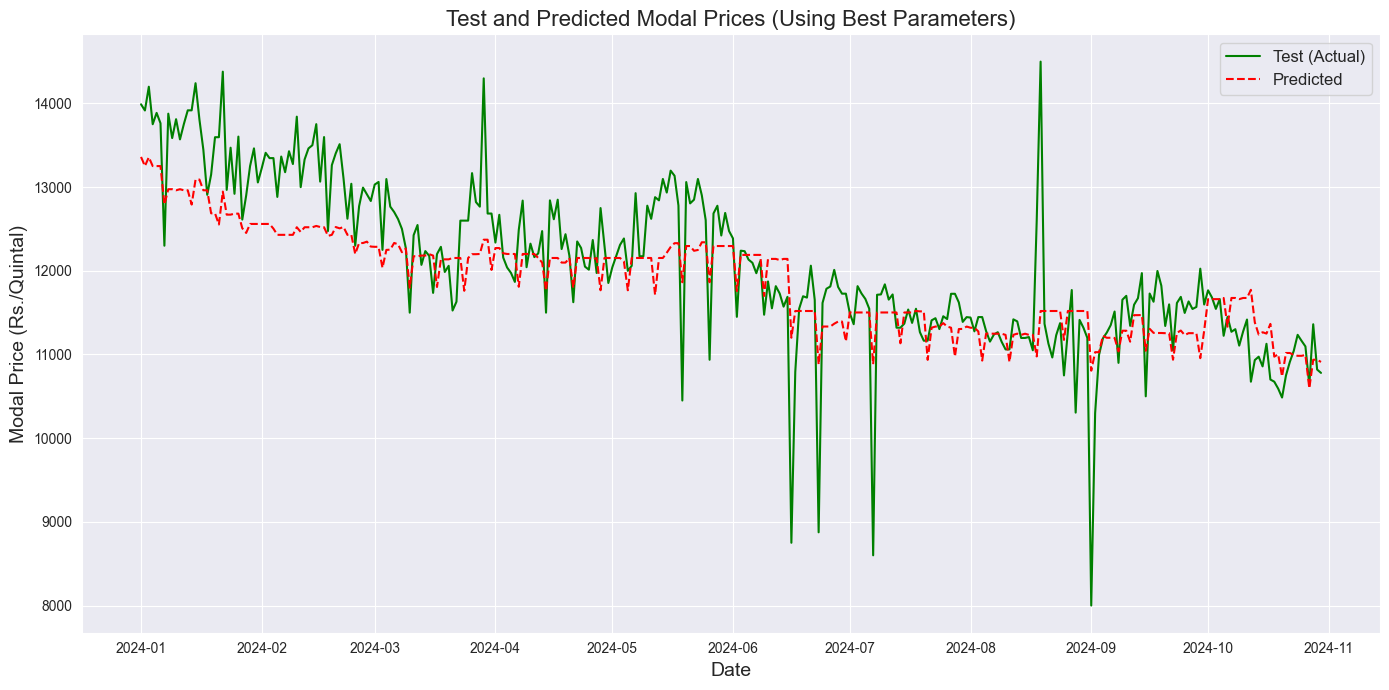

Metrics:
Mean Absolute Error (MAE): 441.3532
Symmetric Mean Absolute Percentage Error (SMAPE): 3.6639
Median Absolute Percentage Error (MDAPE): 2.8256
Geometric Mean Relative Absolute Error (GMRAE): 0.4864


In [16]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2023-12-31']
test_data = df.loc['2024-01-01':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']

# Best parameters from hyperparameter tuning
best_params = {
    'booster': 'gbtree',
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 150,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize the model with the best parameters
model = XGBRegressor(**best_params)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))

# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red', linestyle='--')

# Add title and labels
plt.title("Test and Predicted Modal Prices (Using Best Parameters)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


In [17]:
def calculate_biweekly_metrics(test_data, y_test, y_pred):
    # Ensure the index is in datetime format
    if not pd.api.types.is_datetime64_any_dtype(test_data.index):
        raise TypeError("The index of test_data must be a datetime type.")

    weekly_metrics = []

    # Group by 2-week periods using the index
    for period, period_data in test_data.groupby(pd.Grouper(freq='2W')):
        # Get the integer positions of the indices using get_indexer
        positions = test_data.index.get_indexer(period_data.index)

        # Get actual and predicted values for the current 2-week period
        period_y_true = y_test.iloc[positions]  # Use iloc for integer-based indexing
        period_y_pred = y_pred[positions]  # Use integer-based indexing for numpy array

        # Calculate the metrics for this period
        mae_period = mean_absolute_error(period_y_true, period_y_pred)
        smape_period = smape(period_y_true.values, period_y_pred)
        mdape_period = mdape(period_y_true.values, period_y_pred)
        gmrae_period = gmrae(period_y_true.values, period_y_pred)

        # Store the metrics for the 2-week period
        weekly_metrics.append({
            'Period': period,
            'MAE': mae_period,
            'SMAPE': smape_period,
            'MDAPE': mdape_period,
            'GMRAE': gmrae_period
        })

    return pd.DataFrame(weekly_metrics)

# Calculate 2-week metrics
biweekly_metrics_df = calculate_biweekly_metrics(test_data, y_test, y_pred)

# Print the 2-week metrics
print("2-Week Period Metrics:")
print(biweekly_metrics_df)


2-Week Period Metrics:
       Period         MAE     SMAPE     MDAPE     GMRAE
0  2024-01-07  610.698369  4.528515  4.496369  2.477600
1  2024-01-21  761.180274  5.711790  5.954325  3.621526
2  2024-02-04  676.735484  5.186257  5.556253  3.029876
3  2024-02-18  818.978208  6.320047  6.684664  3.798761
4  2024-03-03  581.988159  4.570249  4.548273  2.703544
5  2024-03-17  304.422064  2.471503  2.492423  0.746416
6  2024-03-31  595.079147  4.747605  4.461188  1.682316
7  2024-04-14  254.603457  2.084460  1.613978  1.023737
8  2024-04-28  321.441579  2.613143  1.546738  1.238067
9  2024-05-12  315.352555  2.561746  1.602721  0.858955
10 2024-05-26  744.277559  6.057360  5.706450  2.076218
11 2024-06-09  195.245028  1.596837  1.223454  0.836876
12 2024-06-23  630.807427  5.870356  3.641570  0.643377
13 2024-07-07  453.668082  4.185666  2.752464  1.108715
14 2024-07-21  189.179971  1.652391  1.725160  0.911650
15 2024-08-04  208.267240  1.832827  0.928533  2.336441
16 2024-08-18  201.920779

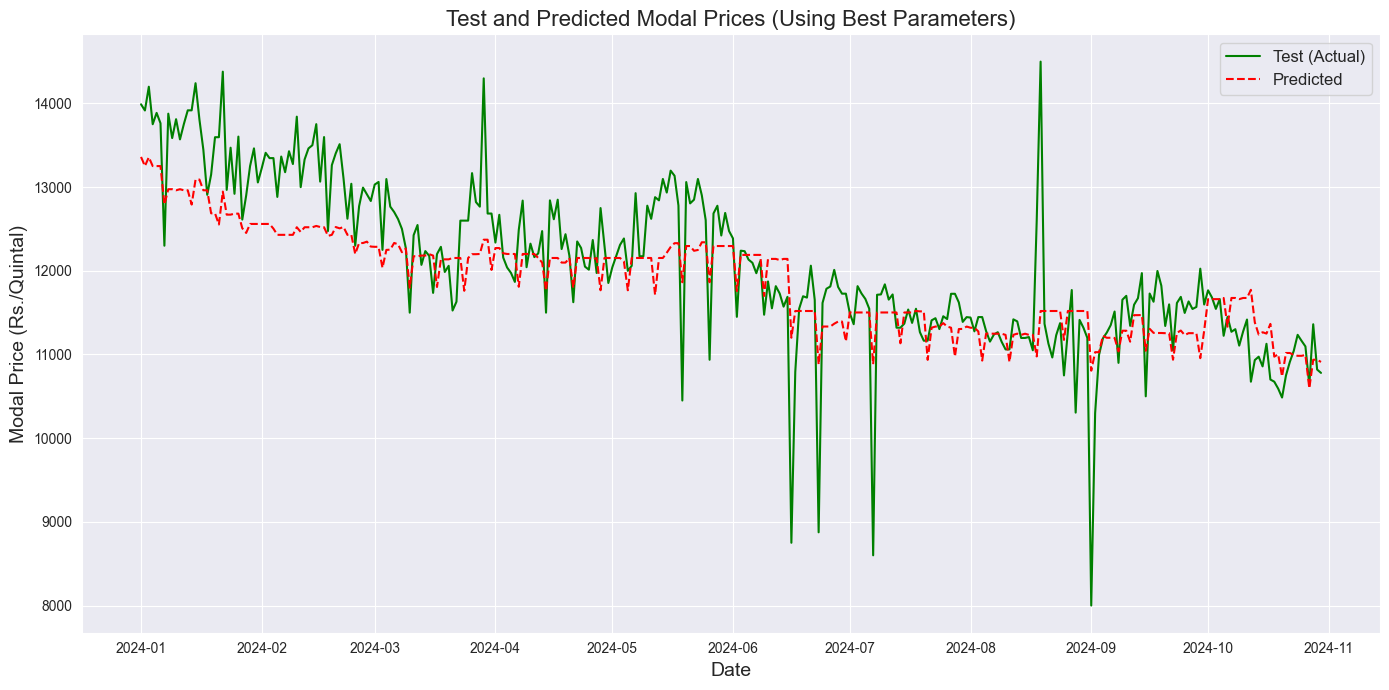

Metrics:
Mean Absolute Error (MAE): 441.3532
Symmetric Mean Absolute Percentage Error (SMAPE): 3.6639
Median Absolute Percentage Error (MDAPE): 2.8256
Geometric Mean Relative Absolute Error (GMRAE): 0.4864


In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error
from xgboost import XGBRegressor

# Assuming `df` contains your data, and it is already prepared with features and target column
# Define train and test data
train_data = df.loc[:'2023-12-31']
test_data = df.loc['2024-01-01':'2024-10-31']

# Extract features and target
feature_columns = [col for col in df.columns if col != 'Modal Price (Rs./Quintal)']
X_train = train_data[feature_columns]
y_train = train_data['Modal Price (Rs./Quintal)']
X_test = test_data[feature_columns]
y_test = test_data['Modal Price (Rs./Quintal)']

# Best parameters from hyperparameter tuning
best_params = {
    'booster': 'gbtree',
    'learning_rate': 0.01,
    'max_depth': 5,
    'n_estimators': 150,
    'objective': 'reg:squarederror',
    'random_state': 42
}

# Initialize the model with the best parameters
model = XGBRegressor(**best_params)

# Train the model
model.fit(X_train, y_train)

# Make predictions
y_pred = model.predict(X_test)

# Add predictions to test data
test_data = test_data.copy()  # Avoid SettingWithCopyWarning
test_data['Predicted'] = y_pred

# Plot
plt.figure(figsize=(14, 7))

# Plot test data (actual values)
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Test (Actual)', color='green')

# Plot predictions
plt.plot(test_data.index, test_data['Predicted'], label='Predicted', color='red', linestyle='--')

# Add title and labels
plt.title("Test and Predicted Modal Prices (Using Best Parameters)", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)

# Show plot
plt.tight_layout()
plt.show()

# Metrics Calculation
def smape(y_true, y_pred):
    """Symmetric Mean Absolute Percentage Error"""
    non_zero_mask = (np.abs(y_true) + np.abs(y_pred)) > 0  # Avoid division by zero
    return 100 * np.mean(2 * np.abs(y_pred[non_zero_mask] - y_true[non_zero_mask]) /
                         (np.abs(y_true[non_zero_mask]) + np.abs(y_pred[non_zero_mask])))

def mdape(y_true, y_pred):
    """Median Absolute Percentage Error"""
    non_zero_mask = y_true != 0  # Avoid division by zero
    return 100 * np.median(np.abs((y_pred[non_zero_mask] - y_true[non_zero_mask]) / y_true[non_zero_mask]))

def gmrae(y_true, y_pred):
    """Geometric Mean Relative Absolute Error"""
    numerator = np.abs(y_true - y_pred)
    denominator = np.abs(y_true - np.mean(y_true))
    ratio = numerator / (denominator + 1e-10)  # Avoid division by zero
    return np.exp(np.mean(np.log(ratio + 1e-10)))

mae = mean_absolute_error(y_test, y_pred)
smape_val = smape(y_test.values, y_pred)
mdape_val = mdape(y_test.values, y_pred)
gmrae_val = gmrae(y_test.values, y_pred)

# Print metrics
print("Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")


Sliding Window Metrics:
Mean Absolute Error (MAE): 450.6934
Symmetric Mean Absolute Percentage Error (SMAPE): 3.7371
Median Absolute Percentage Error (MDAPE): 2.9367
Geometric Mean Relative Absolute Error (GMRAE): 0.5032


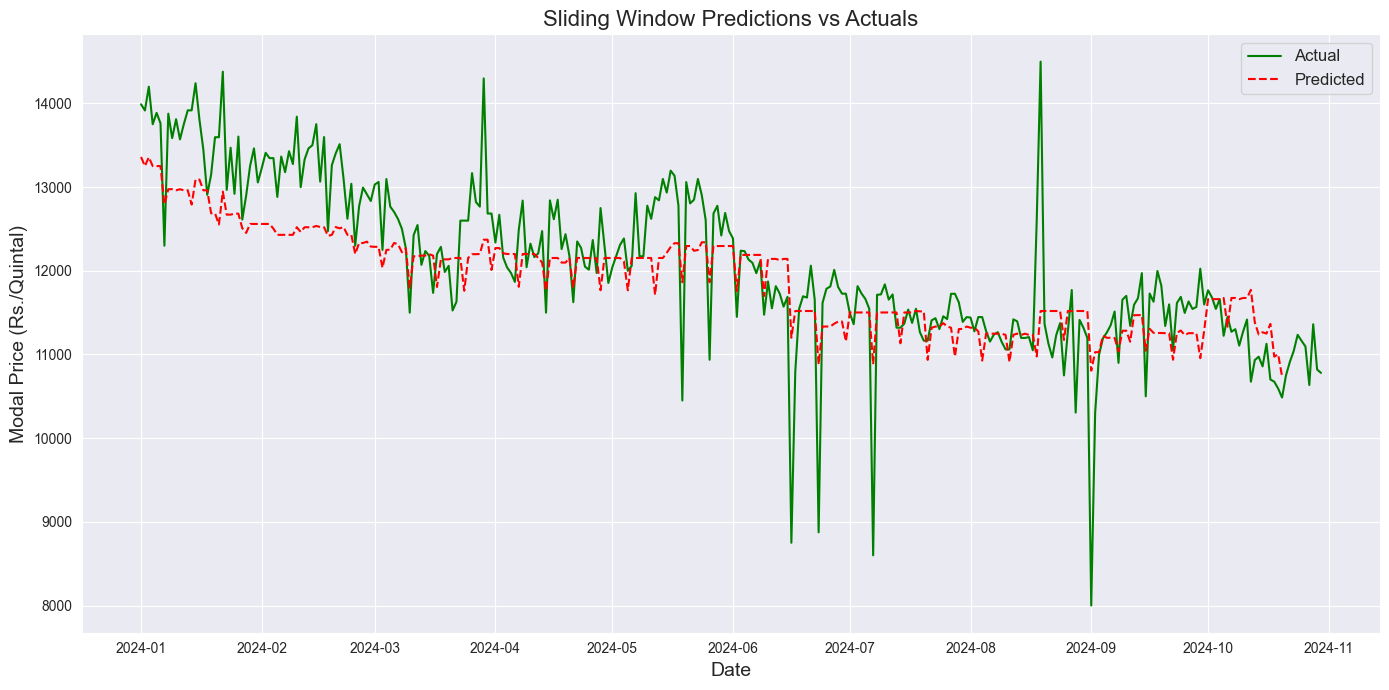

In [19]:
from datetime import timedelta

# Define the sliding window size (2 weeks)
window_size = 14  # Days

# Initialize results storage
all_predictions = []
all_actuals = []

# Start the sliding window process
current_start = test_data.index.min()
current_end = current_start + timedelta(days=window_size - 1)

while current_end <= test_data.index.max():
    # Extract the current window data
    current_window = test_data.loc[current_start:current_end]

    # Extract features and target for the current window
    X_current = current_window[feature_columns]
    y_actual = current_window['Modal Price (Rs./Quintal)']

    # Make predictions for the current window
    y_pred_current = model.predict(X_current)

    # Store predictions and actual values
    all_predictions.extend(y_pred_current)
    all_actuals.extend(y_actual.values)

    # Move the window forward
    current_start = current_end + timedelta(days=1)
    current_end = current_start + timedelta(days=window_size - 1)

# Calculate metrics for the entire test set based on sliding window predictions
mae = mean_absolute_error(all_actuals, all_predictions)
smape_val = smape(np.array(all_actuals), np.array(all_predictions))
mdape_val = mdape(np.array(all_actuals), np.array(all_predictions))
gmrae_val = gmrae(np.array(all_actuals), np.array(all_predictions))

# Print metrics
print("Sliding Window Metrics:")
print(f"Mean Absolute Error (MAE): {mae:.4f}")
print(f"Symmetric Mean Absolute Percentage Error (SMAPE): {smape_val:.4f}")
print(f"Median Absolute Percentage Error (MDAPE): {mdape_val:.4f}")
print(f"Geometric Mean Relative Absolute Error (GMRAE): {gmrae_val:.4f}")

# Plot the predictions vs actual values
plt.figure(figsize=(14, 7))
plt.plot(test_data.index, test_data['Modal Price (Rs./Quintal)'], label='Actual', color='green')
plt.plot(test_data.index[:len(all_predictions)], all_predictions, label='Predicted', color='red', linestyle='--')
plt.title("Sliding Window Predictions vs Actuals", fontsize=16)
plt.xlabel("Date", fontsize=14)
plt.ylabel("Modal Price (Rs./Quintal)", fontsize=14)
plt.legend(fontsize=12)
plt.grid(True)
plt.tight_layout()
plt.show()


In [20]:
import numpy as np
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_squared_error  # Import the necessary function
df = create_features(df)
df_vis = df.copy()
df = df.iloc[df.index<'2024-10-31']
TARGET = 'Modal Price (Rs./Quintal)'
X_all = df.drop(columns=[TARGET])
y_all = df[TARGET]
reg = xgb.XGBRegressor(**best_params)

reg.fit(X_all, y_all, eval_set=[(X_all, y_all), (X_all, y_all)],verbose=100)

[0]	validation_0-rmse:2423.42452	validation_1-rmse:2423.42452
[100]	validation_0-rmse:962.71219	validation_1-rmse:962.71219
[149]	validation_0-rmse:649.57220	validation_1-rmse:649.57220


XGBRegressor(base_score=None, booster='gbtree', callbacks=None,
             colsample_bylevel=None, colsample_bynode=None,
             colsample_bytree=None, device=None, early_stopping_rounds=None,
             enable_categorical=False, eval_metric=None, feature_types=None,
             gamma=None, grow_policy=None, importance_type=None,
             interaction_constraints=None, learning_rate=0.01, max_bin=None,
             max_cat_threshold=None, max_cat_to_onehot=None,
             max_delta_step=None, max_depth=5, max_leaves=None,
             min_child_weight=None, missing=nan, monotone_constraints=None,
             multi_strategy=None, n_estimators=150, n_jobs=None,
             num_parallel_tree=None, random_state=42, ...)

In [21]:
#Create future dataframe
future = pd.date_range('2024-10-31', '2024-11-13', freq='1d')
future_df = pd.DataFrame(index=future)
future_df['isFuture'] = True
df['isFuture'] = False
df_and_future = pd.concat([df, future_df])
df_and_future = create_features(df_and_future)

In [22]:
future_w_features = df_and_future.query('isFuture').copy()

In [23]:
future_w_features2 = future_w_features.drop(columns=[TARGET, 'isFuture'])
future_w_features['pred'] = reg.predict(future_w_features2)

<Axes: title={'center': 'Future Predictions'}>

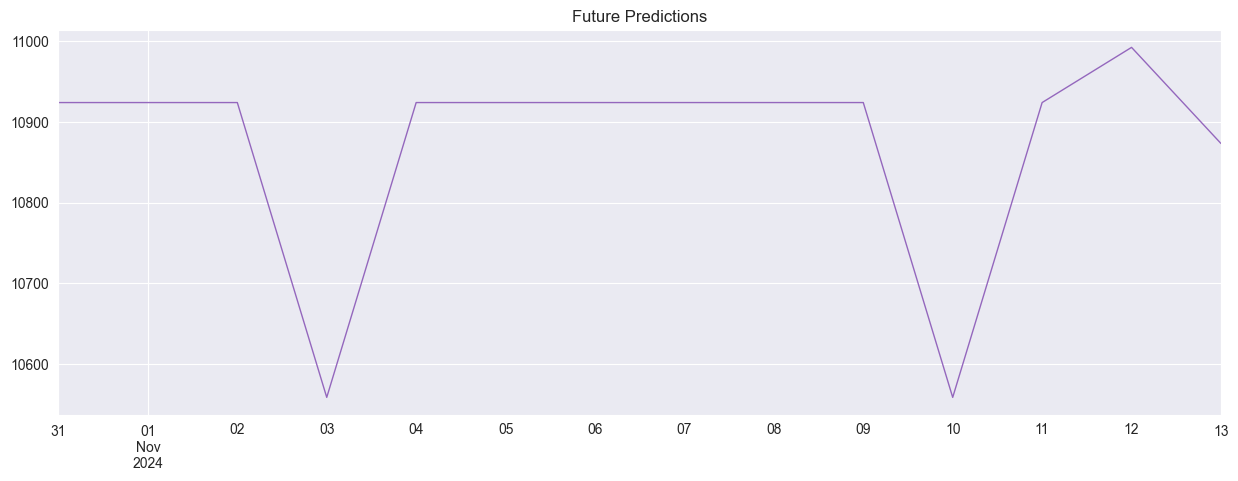

In [24]:
future_w_features['pred'].plot(figsize=(15, 5), color=color_pal[4], ms=1, lw=1, title='Future Predictions')

<Axes: title={'center': 'Future Predictions'}>

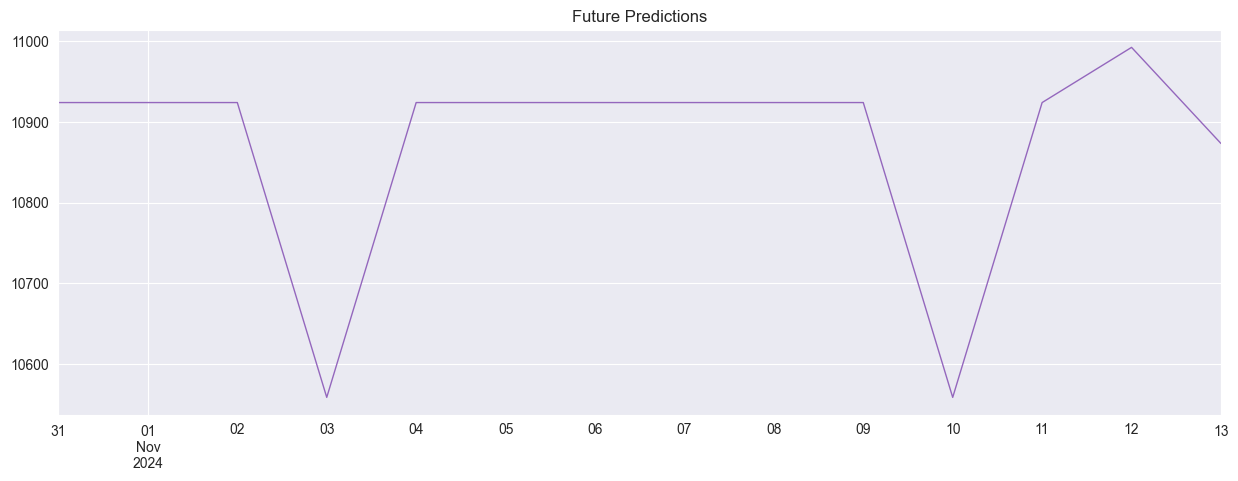

In [25]:
future_w_features['pred'].plot(figsize=(15, 5), color=color_pal[4], ms=1, lw=1, title='Future Predictions')

In [26]:
df_2024 = pd.read_csv("../VolumeData/spice_price_data_2024.csv")
df_2024 = df_2024[df_2024["Variety"]=="White"]

In [27]:
# Rename the column
df_2024 = df_2024.rename(columns={"Reported Date": "Price Date"})

# Verify the changes
print(df_2024.head())


        State Name  District Name           Market Name Variety      Group  \
1          Gujarat         Amreli                Rajula   White  Oil Seeds   
3          Gujarat     Banaskanth                 Deesa   White  Oil Seeds   
9          Gujarat      Bhavnagar  Mahuva(Station Road)   White  Oil Seeds   
17         Gujarat  Surendranagar           Dhragradhra   White  Oil Seeds   
23  Madhya Pradesh          Panna              Ajaygarh   White  Oil Seeds   

   Arrivals (Tonnes) Min Price (Rs./Quintal) Max Price (Rs./Quintal)  \
1               0.60                   12875                   12875   
3               3.30                   10805                   12505   
9               2.30                    6500                   13050   
17              1.40                    9500                   11005   
23              6.10                   10400                   10600   

   Modal Price (Rs./Quintal)   Price Date  
1                      12875  06 Nov 2024  
3         

In [28]:
# Convert 'Price Date' column to datetime, with invalid parsing entries turned into NaT
df_2024["Price Date"] = pd.to_datetime(df_2024["Price Date"], errors="coerce")

# Drop rows where 'Price Date' is NaT after conversion (if needed)
df_2024 = df_2024.dropna(subset=["Price Date"])

# Set 'Price Date' as the index
df_2024.set_index('Price Date', inplace=True)

# Verify the index dtype
index_dtype = df_2024.index.dtype
print(f"Datatype of the index: {index_dtype}")

# Check the resulting DataFrame
print(df_2024.head())


Datatype of the index: datetime64[ns]
                State Name  District Name           Market Name Variety  \
Price Date                                                                
2024-11-06         Gujarat         Amreli                Rajula   White   
2024-11-12         Gujarat     Banaskanth                 Deesa   White   
2024-11-07         Gujarat      Bhavnagar  Mahuva(Station Road)   White   
2024-11-06         Gujarat  Surendranagar           Dhragradhra   White   
2024-11-11  Madhya Pradesh          Panna              Ajaygarh   White   

                Group Arrivals (Tonnes) Min Price (Rs./Quintal)  \
Price Date                                                        
2024-11-06  Oil Seeds              0.60                   12875   
2024-11-12  Oil Seeds              3.30                   10805   
2024-11-07  Oil Seeds              2.30                    6500   
2024-11-06  Oil Seeds              1.40                    9500   
2024-11-11  Oil Seeds             

In [29]:
# Sort df_2024 by 'Price Date' (index)
df_2024 = df_2024.sort_index(ascending=True)
df_2024

,State Name,District Name,Market Name,Variety,Group,Arrivals (Tonnes),Min Price (Rs./Quintal),Max Price (Rs./Quintal),Modal Price (Rs./Quintal)
Price Date,,,,,,,,,
2024-11-02,Karnataka,Bidar,Basava Kalayana,White,Oil Seeds,2.00,7100,9700,8501
2024-11-02,Madhya Pradesh,Gwalior,Lashkar,White,Oil Seeds,3.00,12915,12915,12915
2024-11-03,Uttar Pradesh,Banda,Banda,White,Oil Seeds,40.00,10700,10950,10851
2024-11-03,Madhya Pradesh,Chhatarpur,LavKush Nagar(Laundi),White,Oil Seeds,17.20,9990,11000,11000
2024-11-03,Uttar Pradesh,Jalaun (Orai),Jalaun,White,Oil Seeds,16.00,10800,11500,11251
...,...,...,...,...,...,...,...,...,...
2024-11-13,Gujarat,Surendranagar,Dhragradhra,White,Oil Seeds,0.30,10570,10570,10570
2024-11-13,Gujarat,Amreli,Savarkundla,White,Oil Seeds,5.00,10500,13000,11750
2024-11-13,Gujarat,Amreli,Babra,White,Oil Seeds,0.80,10350,11750,11050


In [30]:
# Convert 'Modal Price (Rs./Quintal)' to float
df_2024['Modal Price (Rs./Quintal)'] = df_2024['Modal Price (Rs./Quintal)'].astype(float)

# Calculate Q1 (25th percentile) and Q3 (75th percentile)
Q1 = df_2024['Modal Price (Rs./Quintal)'].quantile(0.25)
Q3 = df_2024['Modal Price (Rs./Quintal)'].quantile(0.75)

# Calculate the IQR (Interquartile Range)
IQR = Q3 - Q1

# Define lower and upper bounds to identify outliers
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

# Filter out the rows with outliers
df_2024 = df_2024[(df_2024['Modal Price (Rs./Quintal)'] >= lower_bound) & (df_2024['Modal Price (Rs./Quintal)'] <= upper_bound)]

# Verify the result
print(df_2024.head())


                State Name  District Name            Market Name Variety  \
Price Date                                                                 
2024-11-03   Uttar Pradesh          Banda                  Banda   White   
2024-11-03  Madhya Pradesh     Chhatarpur  LavKush Nagar(Laundi)   White   
2024-11-03   Uttar Pradesh  Jalaun (Orai)                 Jalaun   White   
2024-11-04       Karnataka       Kalburgi               Kalburgi   White   
2024-11-04   Uttar Pradesh  Jalaun (Orai)                   Orai   White   

                Group Arrivals (Tonnes) Min Price (Rs./Quintal)  \
Price Date                                                        
2024-11-03  Oil Seeds             40.00                   10700   
2024-11-03  Oil Seeds             17.20                    9990   
2024-11-03  Oil Seeds             16.00                   10800   
2024-11-04  Oil Seeds              2.00                    8000   
2024-11-04  Oil Seeds             16.00                   10000  

In [31]:
df_2024.columns

Index(['State Name', 'District Name', 'Market Name', 'Variety', 'Group',
       'Arrivals (Tonnes)', 'Min Price (Rs./Quintal)',
       'Max Price (Rs./Quintal)', 'Modal Price (Rs./Quintal)'],
      dtype='object')

In [32]:
# Ensure 'Modal Price (Rs./Quintal)' is numeric and coercing errors to NaN
df_2024['Modal Price (Rs./Quintal)'] = pd.to_numeric(df_2024['Modal Price (Rs./Quintal)'], errors='coerce')

# Drop rows with NaN in 'Modal Price (Rs./Quintal)'
df_2024 = df_2024.dropna(subset=['Modal Price (Rs./Quintal)'])

# Now, resample and calculate the mean for only 'Modal Price (Rs./Quintal)'
df_2024_mean = df_2024[['Modal Price (Rs./Quintal)']].resample('D').mean()

# Verify the result
print(df_2024_mean.head())


            Modal Price (Rs./Quintal)
Price Date                           
2024-11-03               11034.000000
2024-11-04               10479.166667
2024-11-05               10561.111111
2024-11-06               10964.321429
2024-11-07               10952.608696


/var/folders/nh/b1_7lrqd3230f7mwnl4b2r3c0000gn/T/ipykernel_7225/733941035.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_2024['Modal Price (Rs./Quintal)'] = pd.to_numeric(df_2024['Modal Price (Rs./Quintal)'], errors='coerce')


In [33]:
df_2024_mean = create_features(df_2024_mean)
df_2024_mean

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag14,lag28,lag42,...,rolling_mean_56,rolling_median_56,rolling_std_56,ema14,ema28,moving_avg_14,moving_avg_28,max_56,min_56,range_56
Price Date,,,,,,,,,,,,,,,,,,,,,
2024-11-03,11034.000000,6,4,11,2024,308,44,10485.714286,11450.000000,11050.000000,...,11034.000000,11034.000000,NaN,11034.000000,11034.000000,11034.000000,11034.000000,11034.0,11034.000000,0.000000
2024-11-04,10479.166667,0,4,11,2024,309,45,10748.242424,11271.484848,11615.393939,...,10756.583333,10756.583333,392.326412,10960.022222,10995.735632,10756.583333,10756.583333,11034.0,10479.166667,554.833333
2024-11-05,10561.111111,1,4,11,2024,310,45,10911.451613,11302.483871,11688.676471,...,10691.425926,10561.111111,299.493690,10906.834074,10965.761527,10691.425926,10691.425926,11034.0,10479.166667,554.833333
2024-11-06,10964.321429,2,4,11,2024,311,45,11042.821429,11106.117647,11496.774194,...,10759.649802,10762.716270,280.027919,10914.499055,10965.662210,10759.649802,10759.649802,11034.0,10479.166667,554.833333
2024-11-07,10952.608696,3,4,11,2024,312,45,11235.054054,11274.642857,11633.807692,...,10798.241580,10952.608696,257.406981,10919.580340,10964.761968,10798.241580,10798.241580,11034.0,10479.166667,554.833333
2024-11-08,10864.142857,4,4,11,2024,313,45,11163.900000,11417.884615,11543.956522,...,10809.225127,10908.375776,231.798431,10912.188676,10957.822719,10809.225127,10809.225127,11034.0,10479.166667,554.833333
2024-11-09,10956.000000,5,4,11,2024,314,45,11096.297297,10675.000000,11568.166667,...,10830.192966,10952.608696,218.753238,10918.030186,10957.697014,10830.192966,10830.192966,11034.0,10479.166667,554.833333
2024-11-10,10542.857143,6,4,11,2024,315,45,10635.166667,10933.333333,12025.500000,...,10794.275988,10908.375776,226.576860,10868.007113,10929.087368,10794.275988,10794.275988,11034.0,10479.166667,554.833333
2024-11-11,10857.031250,0,4,11,2024,316,46,11361.281250,10973.571429,11597.147059,...,10801.248795,10864.142857,212.973049,10866.543665,10924.117980,10801.248795,10801.248795,11034.0,10479.166667,554.833333


In [34]:
df_2024_mean

,Modal Price (Rs./Quintal),dayofweek,quarter,month,year,dayofyear,weekofyear,lag14,lag28,lag42,...,rolling_mean_56,rolling_median_56,rolling_std_56,ema14,ema28,moving_avg_14,moving_avg_28,max_56,min_56,range_56
Price Date,,,,,,,,,,,,,,,,,,,,,
2024-11-03,11034.000000,6,4,11,2024,308,44,10485.714286,11450.000000,11050.000000,...,11034.000000,11034.000000,NaN,11034.000000,11034.000000,11034.000000,11034.000000,11034.0,11034.000000,0.000000
2024-11-04,10479.166667,0,4,11,2024,309,45,10748.242424,11271.484848,11615.393939,...,10756.583333,10756.583333,392.326412,10960.022222,10995.735632,10756.583333,10756.583333,11034.0,10479.166667,554.833333
2024-11-05,10561.111111,1,4,11,2024,310,45,10911.451613,11302.483871,11688.676471,...,10691.425926,10561.111111,299.493690,10906.834074,10965.761527,10691.425926,10691.425926,11034.0,10479.166667,554.833333
2024-11-06,10964.321429,2,4,11,2024,311,45,11042.821429,11106.117647,11496.774194,...,10759.649802,10762.716270,280.027919,10914.499055,10965.662210,10759.649802,10759.649802,11034.0,10479.166667,554.833333
2024-11-07,10952.608696,3,4,11,2024,312,45,11235.054054,11274.642857,11633.807692,...,10798.241580,10952.608696,257.406981,10919.580340,10964.761968,10798.241580,10798.241580,11034.0,10479.166667,554.833333
2024-11-08,10864.142857,4,4,11,2024,313,45,11163.900000,11417.884615,11543.956522,...,10809.225127,10908.375776,231.798431,10912.188676,10957.822719,10809.225127,10809.225127,11034.0,10479.166667,554.833333
2024-11-09,10956.000000,5,4,11,2024,314,45,11096.297297,10675.000000,11568.166667,...,10830.192966,10952.608696,218.753238,10918.030186,10957.697014,10830.192966,10830.192966,11034.0,10479.166667,554.833333
2024-11-10,10542.857143,6,4,11,2024,315,45,10635.166667,10933.333333,12025.500000,...,10794.275988,10908.375776,226.576860,10868.007113,10929.087368,10794.275988,10794.275988,11034.0,10479.166667,554.833333
2024-11-11,10857.031250,0,4,11,2024,316,46,11361.281250,10973.571429,11597.147059,...,10801.248795,10864.142857,212.973049,10866.543665,10924.117980,10801.248795,10801.248795,11034.0,10479.166667,554.833333


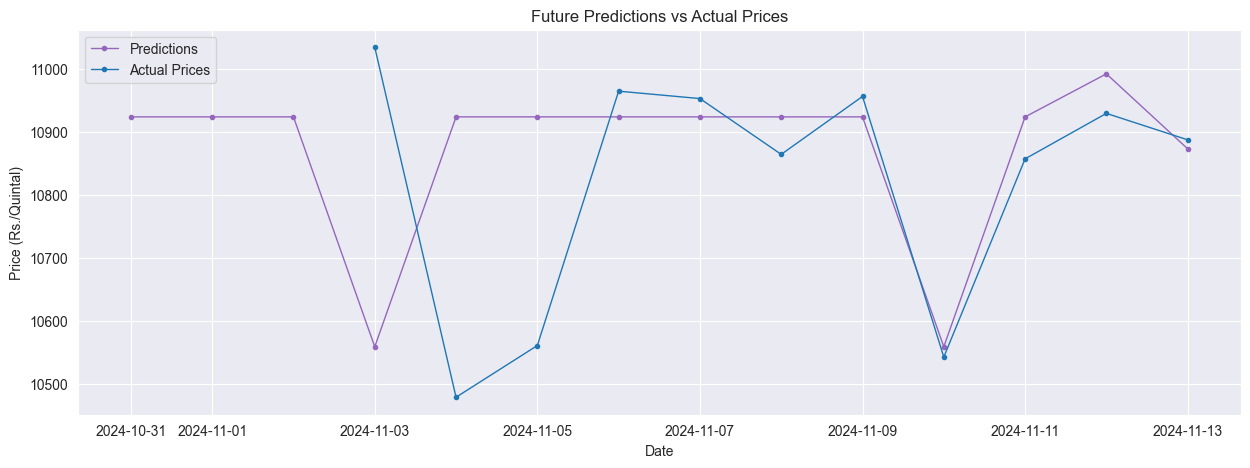

In [35]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15, 5))

plt.plot(future_w_features['pred'], color=color_pal[4], marker='o', markersize=3, linewidth=1, label='Predictions')

plt.plot(df_2024_mean['Modal Price (Rs./Quintal)'], color=color_pal[0], marker='o', markersize=3, linewidth=1, label='Actual Prices')

plt.title('Future Predictions vs Actual Prices')
plt.xlabel('Date')
plt.ylabel('Price (Rs./Quintal)')
plt.legend()
plt.show()


In [36]:
from sklearn.metrics import mean_absolute_error

# Ensure both series are aligned by index
actual_prices = df_2024_mean['Modal Price (Rs./Quintal)']
predicted_prices = future_w_features['pred']

# Calculate MAE
mae = mean_absolute_error(actual_prices, predicted_prices)

# Print the MAE
print(f"Mean Absolute Error (MAE): {mae:.4f}")


ValueError: Found input variables with inconsistent numbers of samples: [11, 14]